In [5]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Permute,  Reshape
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply

K.set_image_dim_ordering("th")
SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs,timesteps):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps=timesteps
    print(input_dim)
    print(time_steps)
    a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1))(a) #, name='dim_reduction'
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a) #, name='attention_vec ' % (depth)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul= Multiply()([inputs, a_probs]) #name='attention_mul'
    return output_attention_mul


class LSTMATTBFnet:
    @staticmethod
    def build(timeSteps,variables,classes):
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True

        lstm=LSTM(100,recurrent_dropout=0.1,dropout=0.1,return_sequences=True)(inputNet) #worse using stateful=True 
        attention_mul = attention_3d_block(lstm,timeSteps)
        attention_mul = Flatten()(attention_mul)
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(attention_mul)
        
        model=Model(inputNet,classificationLayer)
        return model


In [6]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,72,8))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(2876, 72, 8)
2876
############# train shapes #############
(2301, 72, 8)
(2301, 1)
############# test shapes #############
(575, 72, 8)
(575, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [7]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = LSTMATTBFnet.build(timeSteps=IMG_ROWS,variables=IMG_COLS,classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(575, 5)
100
72


ValueError: Dimensions must be equal, but are 100 and 72 for 'dense_1_1/add' (op: 'Add') with input shapes: [?,100,72], [1,72,1].

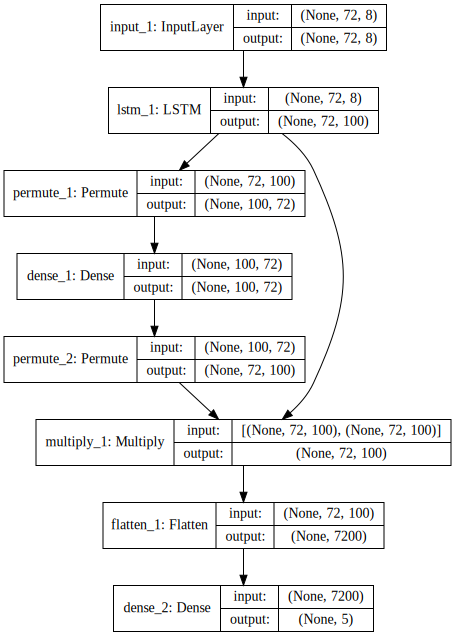

In [6]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [7]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('LSTM-ATTENTION-BF-energie.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

W0615 14:11:30.380663 140322434881408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2301 samples, validate on 575 samples
Epoch 1/100
2301/2301 [==============================] - 7s 3ms/step - loss: 1.5886 - acc: 0.2542 - val_loss: 1.6377 - val_acc: 0.2296

Epoch 00001: val_acc improved from -inf to 0.22957, saving model to LSTM-ATTENTION-BF-energie.h5
Epoch 2/100
2301/2301 [==============================] - 5s 2ms/step - loss: 1.5634 - acc: 0.3007 - val_loss: 1.5863 - val_acc: 0.2174

Epoch 00002: val_acc did not improve from 0.22957
Epoch 3/100
2301/2301 [==============================] - 5s 2ms/step - loss: 1.5747 - acc: 0.2625 - val_loss: 1.5755 - val_acc: 0.2313

Epoch 00003: val_acc improved from 0.22957 to 0.23130, saving model to LSTM-ATTENTION-BF-energie.h5
Epoch 4/100
2301/2301 [==============================] - 5s 2ms/step - loss: 1.5249 - acc: 0.3060 - val_loss: 1.5361 - val_acc: 0.2417

Epoch 00004: val_acc improved from 0.23130 to 0.24174, saving model to LSTM-ATTENTION-BF-energie.h5
Epoch 5/100
2301/2301 [==============================] - 5s 2m

In [0]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('LSTM-ATTENTION-BF-energie.hist',history)
hist=loadHist('LSTM-ATTENTION-BF-energie.hist')




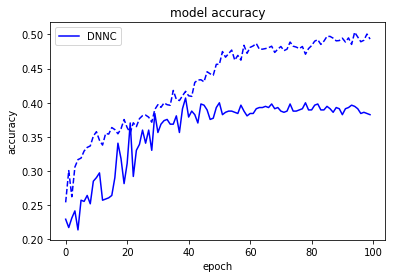

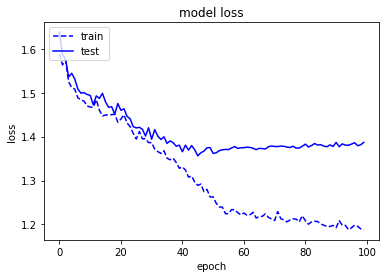

In [9]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
from keras.models import load_model
model = load_model('LSTM-ATTENTION-BF-energie.h5')

ValueError: Dimensions must be equal, but are 100 and 72 for 'dense_1_2/add' (op: 'Add') with input shapes: [?,100,72], [1,72,1].

In [3]:
from sklearn.metrics import classification_report, confusion_matrix


print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)


Confusion Matrix


NameError: name 'y_test' is not defined